# Distributed CBO -- Benchmark and Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

from dataclasses import dataclass
import math
import time
from typing import List

import matplotlib.pyplot as plt
import numpy as np

from cbx.dynamics import CBO, DistributedCBO
from cbx.objectives import Rastrigin, Ackley, Michalewicz
import cbx.utils.termination as term

# CBO Configuration

In [2]:
conf = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,
    'lamda': 1.0,
    'term_criteria': [term.max_it_term(100)],
    'track_args': {'names': ['update_norm', 'energy', 'x', 'consensus', 'drift']},

    'noise': 'anisotropic',
    'f_dim': '3D'
}

# Define Benchmarking Functions

In [3]:
def benchmark_distributed_cbo_splitting_factor(
    f: callable,
    num_runs: int,
    max_splitting_factor: int,
    max_particles: int,
    synchronization_interval: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin: float =0,
    success_eps: float = 1e-6
):  
    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rates = {splitting_factor: 0 for splitting_factor in range(1, max_splitting_factor + 1)}
    for splitting_factor in range(1, max_splitting_factor + 1):
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                use_async_communication=use_async_communication,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            # Check if we found true minimum
            if abs(current_energies[-1] - fmin) < success_eps:
                success_rates[splitting_factor] += 1

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Splitting factor: {splitting_factor}, average energy: {average_energy}, success_rate: {success_rates[splitting_factor] / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.plot(list(range(1, max_splitting_factor + 1)), energy_means, label=f'Distributed CBO {async_label}')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        axs.fill_between(list(range(1, max_splitting_factor + 1)), quantile_10, quantile_90, alpha=0.3, label='90% CI')

    return int(np.argmin(energy_means) + 1)


In [4]:
def benchmark_distributed_cbo_synchronization_interval(
    f: callable,
    num_runs: int,
    synchronization_intervals: List[int],
    max_particles: int,
    splitting_factor: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin=0
):  
    energy_means = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rates = {synchronization_interval: 0 for synchronization_interval in synchronization_intervals}
    for synchronization_interval in synchronization_intervals:
        num_particles = math.ceil(max_particles / splitting_factor)
        current_energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                use_async_communication=use_async_communication,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            current_energies.append(
                f(dyn.optimize(num_steps=num_steps, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

            # Check if we found true minimum
            if abs(current_energies[-1] - fmin) < 1e-3:
                success_rates[synchronization_interval] += 1

            function_evaluations.append(dyn.num_f_eval())

        average_energy = np.median(current_energies)
        average_function_evaluations = np.mean(function_evaluations)
        print(f"Synchronization interval: {synchronization_interval}, average energy: {average_energy}, success_rate: {success_rates[synchronization_interval] / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
        energy_means.append(average_energy)

        quantile_10.append(np.percentile(current_energies, 5))
        quantile_90.append(np.percentile(current_energies, 95))

    if axs is not None:
        async_label = 'Async' if use_async_communication else 'Sync'
        axs.set_xscale('log')
        axs.plot(synchronization_intervals, energy_means, label=f'Distributed CBO {async_label}')
        # axs.set_xticks(synchronization_intervals)
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        # axs.fill_between(synchronization_intervals, quantile_10, quantile_90, alpha=0.3, label='90% CI')


In [5]:
def benchmark_standard_cbo(
    f: callable,
    num_runs: int,
    num_particles: int,
    axs=None,
    fmin=0
):
    energies = []
    execution_times = []
    function_evaluations = []
    quantile_10 = []
    quantile_90 = []
    success_rate = 0
    for _ in range(num_runs):
        dyn = CBO(
            f,
            N=num_particles,
            verbosity=0,
            max_it=10000,
            batch_args=None,
            M=1,
            **conf
        )

        # Run optimization and measure time
        tick = time.time()
        energies.append(
            f(dyn.optimize())
        )
        tock = time.time()
        execution_times.append(tock - tick)

        if abs(energies[-1] - fmin) < 1e-3:
            success_rate += 1

        function_evaluations.append(dyn.num_f_eval)

    average_energy = np.median(energies)
    average_function_evaluations = np.mean(function_evaluations)
    print(f"Average energy: {average_energy}, success_rate: {success_rate / num_runs}, function evaluations: {average_function_evaluations}, execution time: {np.mean(execution_times)}")
    quantile_10.append(np.percentile(energies, 5))
    quantile_90.append(np.percentile(energies, 95))

    # Plot mean of undistributed energies as a horizontal line
    if axs is not None:
        axs.axhline(y=average_energy, color='r', linestyle='--', label='Standard CBO')
        # Plot shaded confidence interval for energy from 10th to 90th percentile
        # axs.fill_between([0, 1], quantile_10, quantile_90, alpha=0.3, label='90% CI')


# Benchmark

In [6]:
# Benchmarking params
NUM_RUNS = 100
MAX_SPLITTING_FACTOR = 10
MAX_PARTICLES = 100
SYNCHRONIZATION_INTERVAL = 10
SYNCHRONIZATION_METHOD = 'weighted_mean'

In [7]:
def run_experiment(
    f: callable,
    d: int,
    n: int,
):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    conf['d'] = d
    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs[0]
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    best_splitting_factor_sync = benchmark_distributed_cbo_splitting_factor(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[0]
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    best_splitting_factor_async = benchmark_distributed_cbo_splitting_factor(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        max_splitting_factor=MAX_SPLITTING_FACTOR,
        max_particles=n,
        synchronization_interval=SYNCHRONIZATION_INTERVAL,
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[0]
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs[0].set_xlabel(f"Splitting factor")
    axs[0].set_ylabel(f"Mean energy")
    axs[0].set_title(f"{function_label}\nsync interval: {SYNCHRONIZATION_INTERVAL}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs[0].legend()

    ############################################################################

    # Baseline (standard CBO)
    print("Standard CBO:")
    print("=============")
    benchmark_standard_cbo(
        f=f,
        num_runs=NUM_RUNS,
        num_particles=n,
        axs=axs[1]
    )
    print()

    # Synchronous
    print("Distributed CBO (synchronous communication):")
    print("=============================================")
    """
    f: callable,
    num_runs: int,
    synchronization_intervals: List[int],
    max_particles: int,
    splitting_factor: int,
    synchronization_method: str,
    num_steps: int,
    use_async_communication: bool = False,
    axs=None,
    fmin=0
    """
    benchmark_distributed_cbo_synchronization_interval(
        f=f,
        use_async_communication=False,
        num_runs=NUM_RUNS,
        splitting_factor=best_splitting_factor_sync,
        max_particles=n,
        synchronization_intervals=[1, 10, 20, 30, 40, 50, 200],
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[1]
    )
    print()

    # Asynchronous
    print("Distributed CBO (asynchronous communication):")
    print("==============================================")
    benchmark_distributed_cbo_synchronization_interval(
        f=f,
        use_async_communication=True,
        num_runs=NUM_RUNS,
        splitting_factor=best_splitting_factor_async,
        max_particles=n,
        synchronization_intervals=[1, 10, 20, 30, 40, 50, 200],
        synchronization_method=SYNCHRONIZATION_METHOD,
        num_steps=100,
        axs=axs[1]
    )
    print()

    function_label = f.__class__.__name__ + f" dim={d}"
    axs[1].set_xlabel(f"Synchronization interval")
    axs[1].set_ylabel(f"Mean energy")
    axs[1].set_title(f"{function_label}\nsplitting factor (sync, async): {best_splitting_factor_sync, best_splitting_factor_async}, sync method: {SYNCHRONIZATION_METHOD}, particles: {n}")
    axs[1].legend()
    
    fig.show()

## Ackley, Rastrigin (d = 5, 10, 20; N = 50, 100, 200, 1000)

Standard CBO:
Average energy: 0.018355807406479574, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.007371158599853516

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.017085388614598518, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.015073919296264648
Splitting factor: 2, average energy: 0.017564905730422797, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.01811885952949524
Splitting factor: 3, average energy: 0.021335379832330137, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.027354435920715334
Splitting factor: 4, average energy: 0.022263972059124004, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.029024571776390076
Splitting factor: 5, average energy: 0.029881478504425463, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.03253352117538452
Splitting factor: 6, average energy: 0.03086224101403312, success_rate: 0.0, func

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.17784544735830432, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.006375572681427002

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.036251118612058875, success_rate: 0.02, function evaluations: 5050.0, execution time: 0.014642992019653321
Splitting factor: 2, average energy: 0.04051904617553941, success_rate: 0.05, function evaluations: 5050.0, execution time: 0.015714017152786256
Splitting factor: 3, average energy: 0.02548530557331965, success_rate: 0.02, function evaluations: 5083.666666666667, execution time: 0.018599002361297606
Splitting factor: 4, average energy: 0.03133103324146251, success_rate: 0.03, function evaluations: 5125.75, execution time: 0.02200444996356964
Splitting factor: 5, average energy: 0.03427804036052998, success_rate: 0.03, function evaluations: 5110.6, execution time: 0.025828763484954834
Splitting factor: 6, average energy: 0.03367961956416003, success_rate: 0.01, function evaluat

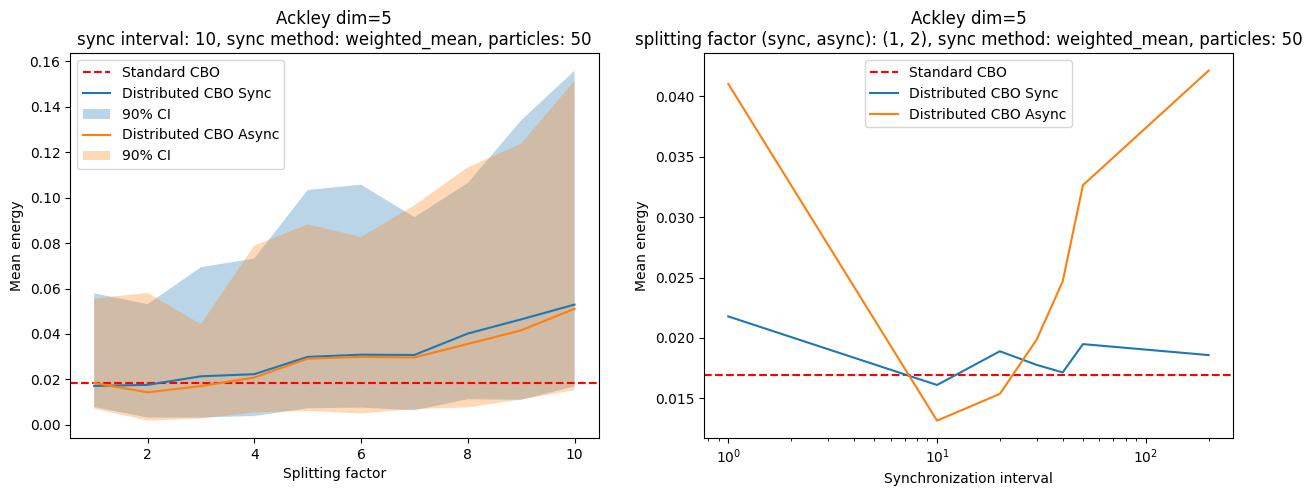

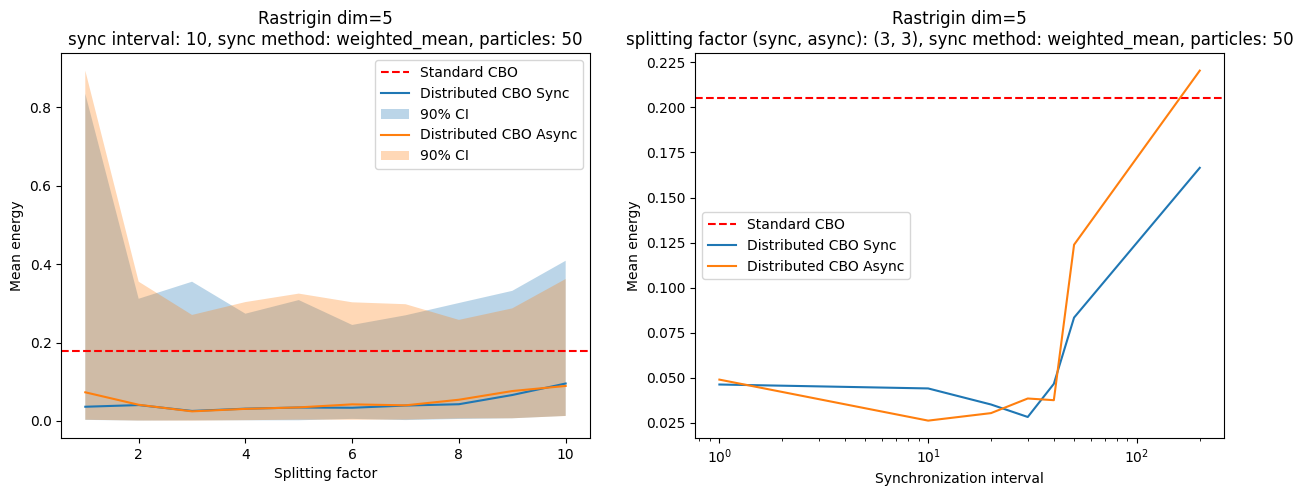

In [8]:
run_experiment(Ackley(), d=5, n=50)
run_experiment(Rastrigin(), d=5, n=50)

Standard CBO:
Average energy: 0.1473305899177526, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.0075768113136291506

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.13393650862820872, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.01660806894302368
Splitting factor: 2, average energy: 0.12572630932972517, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.018151670694351196
Splitting factor: 3, average energy: 0.12467842227648385, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.021446909109751385
Splitting factor: 4, average energy: 0.1420316610794239, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.02499422609806061
Splitting factor: 5, average energy: 0.15913736156533576, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.028780611038208007
Splitting factor: 6, average energy: 0.14853385030200394, success_rate: 0.0, function ev

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.585393811859039, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.0070884633064270015

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.5220573410550498, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.014255216121673584
Splitting factor: 2, average energy: 0.407948331475538, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.015791850090026857
Splitting factor: 3, average energy: 0.390200734747101, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.01993496815363566
Splitting factor: 4, average energy: 0.412883556520888, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.023503210544586182
Splitting factor: 5, average energy: 0.47966170315007495, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.02743278121948242
Splitting factor: 6, average energy: 0.452904981366111, success_rate: 0.0, function evaluations: 5167.8333333

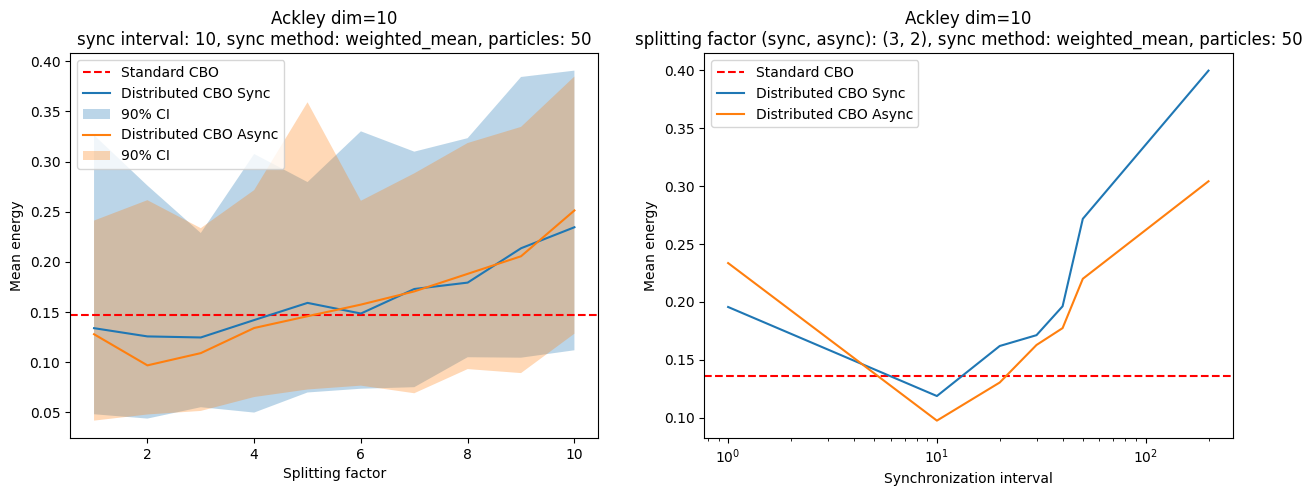

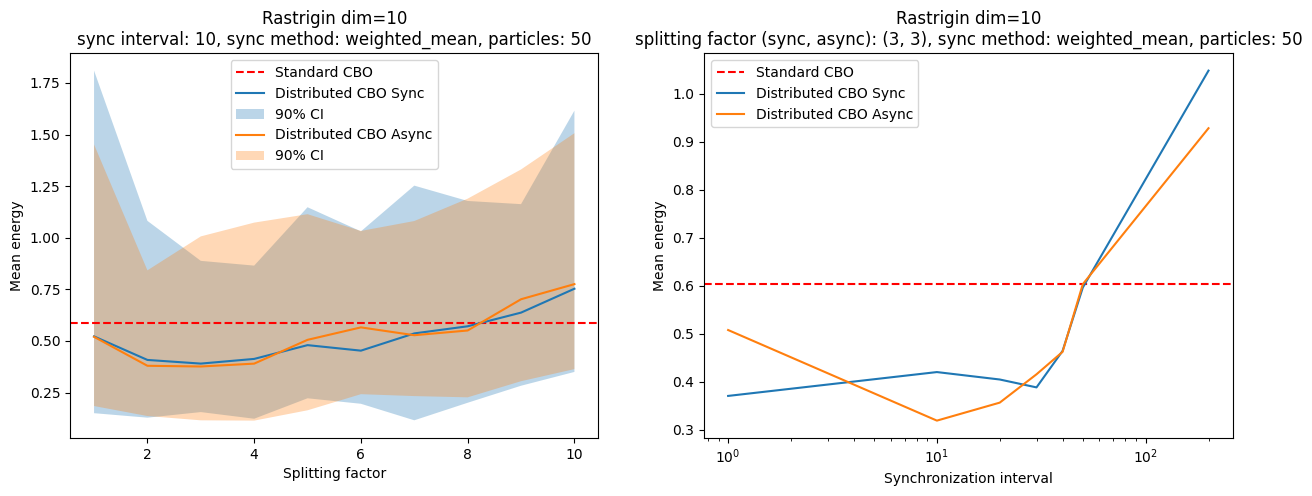

In [9]:
run_experiment(Ackley(), d=10, n=50)
run_experiment(Rastrigin(), d=10, n=50)

Standard CBO:
Average energy: 0.43430870532698274, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.008644559383392335

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.45651443630092503, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.01701716423034668
Splitting factor: 2, average energy: 0.34590153450412453, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.019219694137573243
Splitting factor: 3, average energy: 0.3764479617344745, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.022665072282155356
Splitting factor: 4, average energy: 0.3779468001622104, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.027999948859214783
Splitting factor: 5, average energy: 0.4244732432096936, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.03205980348587036
Splitting factor: 6, average energy: 0.37932541500375594, success_rate: 0.0, function eval

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 1.5951776977148073, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.008632166385650635

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 1.523797434352119, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.0170238995552063
Splitting factor: 2, average energy: 1.2628382062581327, success_rate: 0.0, function evaluations: 5050.0, execution time: 0.02034990310668945
Splitting factor: 3, average energy: 1.3310003263245194, success_rate: 0.0, function evaluations: 5083.666666666667, execution time: 0.02298910140991211
Splitting factor: 4, average energy: 1.4748434717467998, success_rate: 0.0, function evaluations: 5125.75, execution time: 0.02600546717643738
Splitting factor: 5, average energy: 1.6623235963713652, success_rate: 0.0, function evaluations: 5110.6, execution time: 0.029770387172698975
Splitting factor: 6, average energy: 1.542559477303783, success_rate: 0.0, function evaluations: 5167.833333333

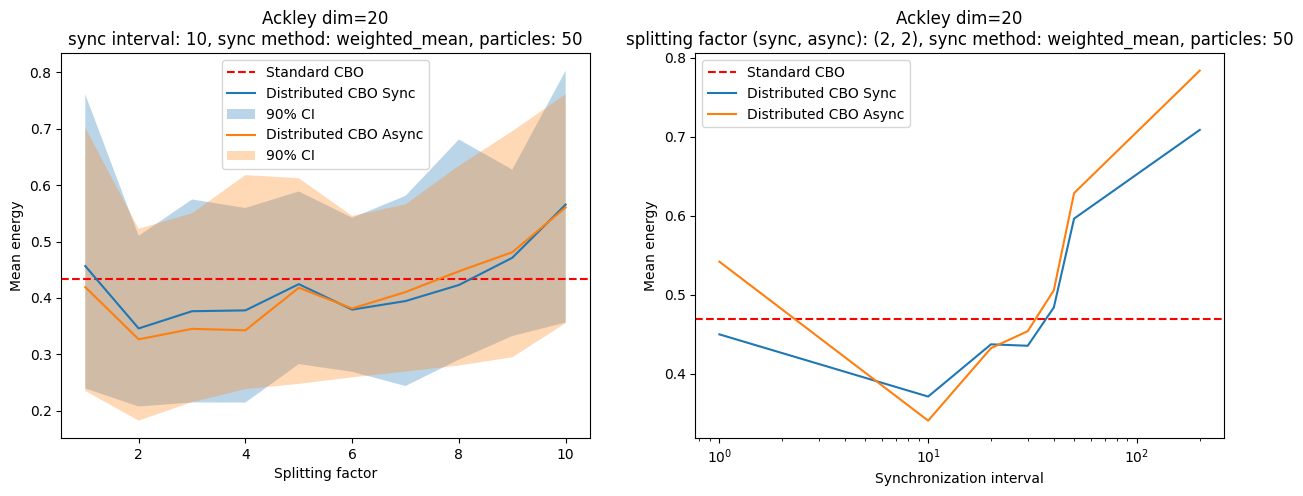

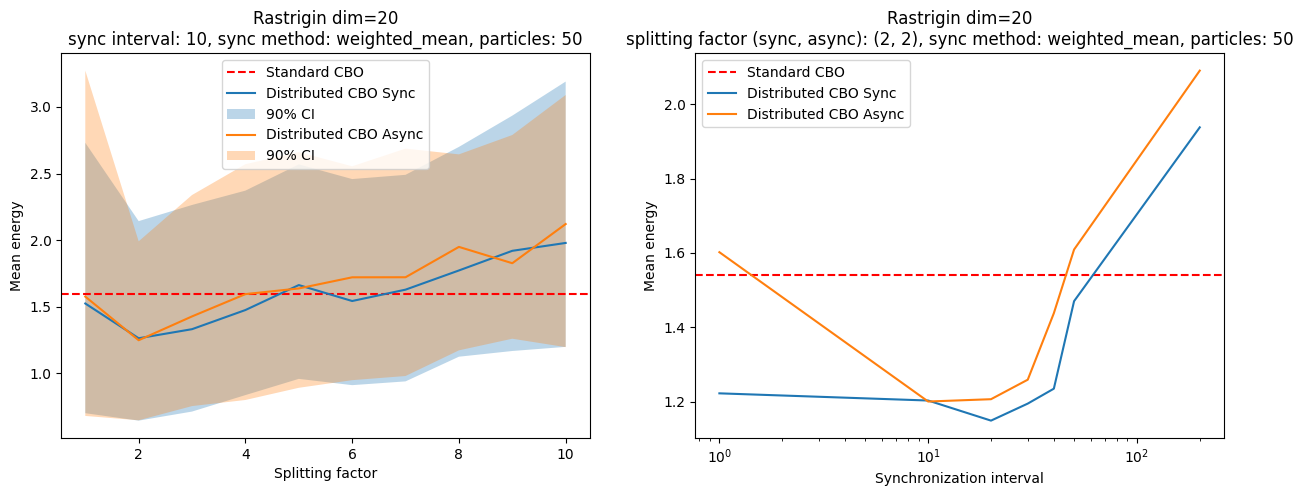

In [10]:
run_experiment(Ackley(), d=20, n=50)
run_experiment(Rastrigin(), d=20, n=50)

Standard CBO:
Average energy: 0.009460650041417384, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.007502825260162354

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.011323138416817091, success_rate: 0.01, function evaluations: 10100.0, execution time: 0.015269429683685302
Splitting factor: 2, average energy: 0.010283442933932907, success_rate: 0.02, function evaluations: 10100.0, execution time: 0.016907312870025636
Splitting factor: 3, average energy: 0.00792235452386203, success_rate: 0.02, function evaluations: 10167.333333333334, execution time: 0.020287209351857502
Splitting factor: 4, average energy: 0.007200983802315708, success_rate: 0.05, function evaluations: 10150.5, execution time: 0.023900196552276612
Splitting factor: 5, average energy: 0.011034168693584423, success_rate: 0.02, function evaluations: 10140.4, execution time: 0.02758009433746338
Splitting factor: 6, average energy: 0.008985506356831596, success_rate

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.007216894461463853, success_rate: 0.08, function evaluations: 10100.0, execution time: 0.007422025203704834

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.008154591925937461, success_rate: 0.06, function evaluations: 10100.0, execution time: 0.01554499626159668
Splitting factor: 2, average energy: 0.004353891626438866, success_rate: 0.15, function evaluations: 10100.0, execution time: 0.016895127296447755
Splitting factor: 3, average energy: 0.003774743893643873, success_rate: 0.18, function evaluations: 10167.333333333334, execution time: 0.02007198174794515
Splitting factor: 4, average energy: 0.004043061742504861, success_rate: 0.25, function evaluations: 10150.5, execution time: 0.02325188934803009
Splitting factor: 5, average energy: 0.006073385683823674, success_rate: 0.12, function evaluations: 10140.4, execution time: 0.027829466819763185
Splitting factor: 6, average energy: 0.006281983501189182, success_rate: 0.16, functi

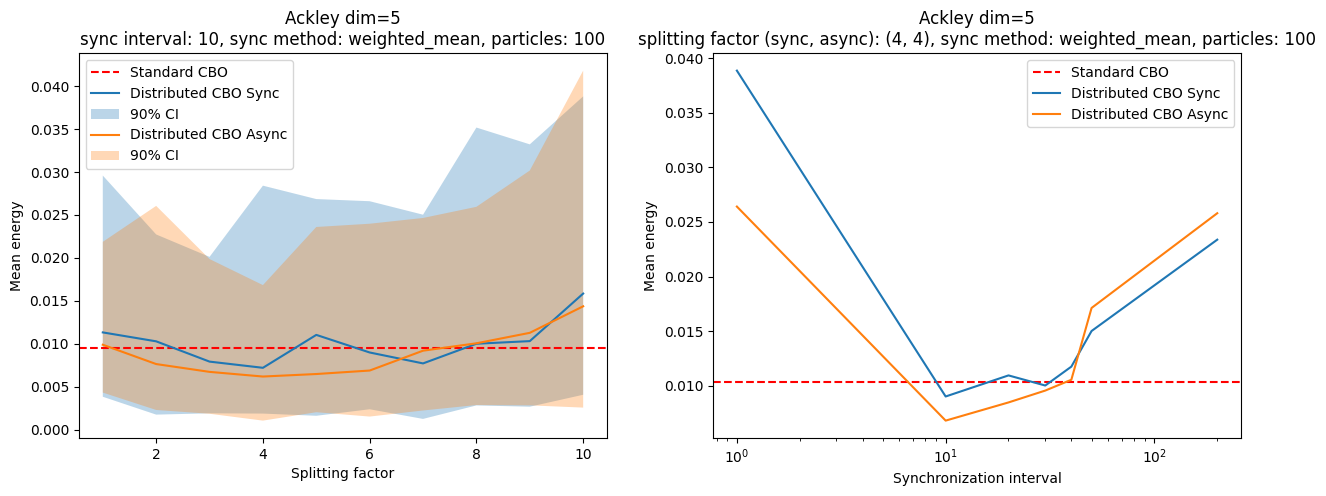

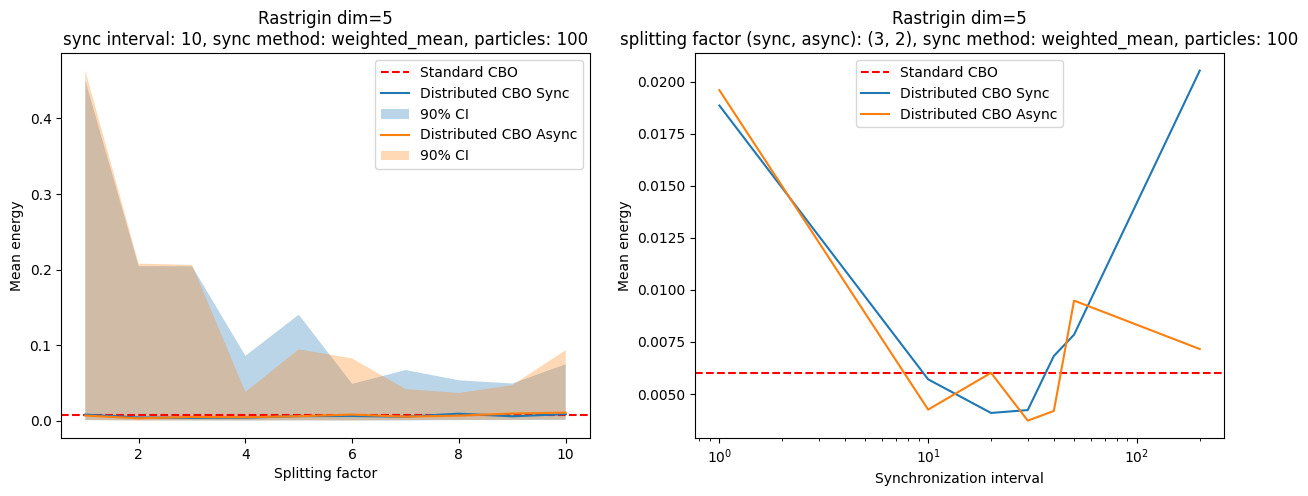

In [11]:
run_experiment(Ackley(), d=5, n=100)
run_experiment(Rastrigin(), d=5, n=100)

Standard CBO:
Average energy: 0.050546089158956864, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.009128785133361817

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.05607765124603015, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.017355937957763672
Splitting factor: 2, average energy: 0.04305814232279781, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.019049938917160034
Splitting factor: 3, average energy: 0.050135615311753146, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.02279333511988322
Splitting factor: 4, average energy: 0.056363788990861696, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.026497520208358764
Splitting factor: 5, average energy: 0.06226560664699621, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.03134586381912231
Splitting factor: 6, average energy: 0.06658526721669356, success_rate: 0.0, fu

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.29461878824355586, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.008990569114685059

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.2460150144343411, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.016806375980377198
Splitting factor: 2, average energy: 0.20064933939334387, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.018639004230499266
Splitting factor: 3, average energy: 0.17835019877272087, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.021929487387339273
Splitting factor: 4, average energy: 0.1806517112831263, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.025489624738693237
Splitting factor: 5, average energy: 0.20438803660334504, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.02922991895675659
Splitting factor: 6, average energy: 0.2131876921666506, success_rate: 0.0, function evaluations:

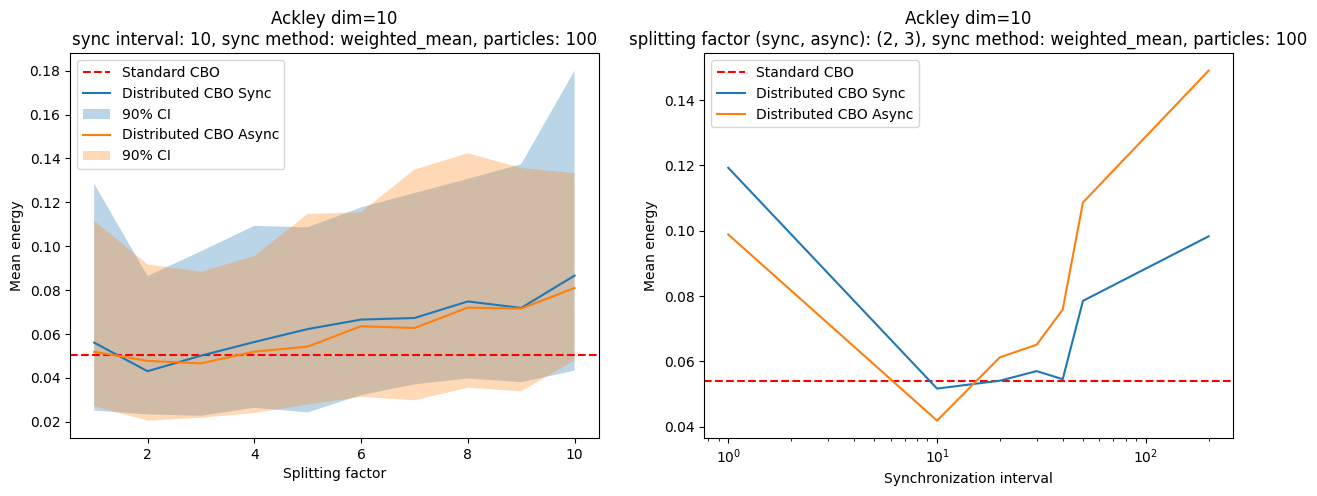

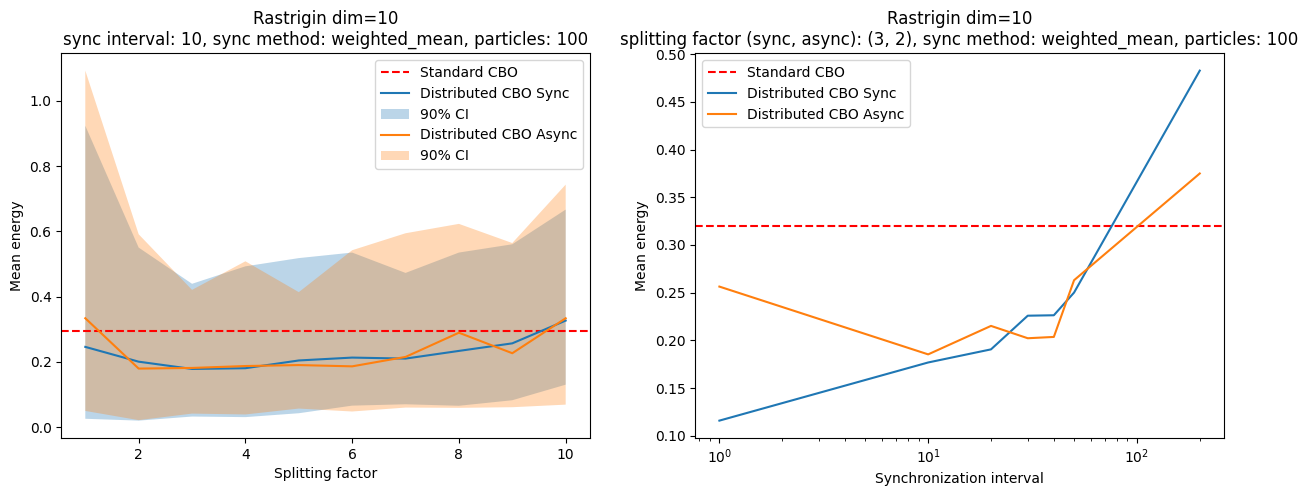

In [12]:
run_experiment(Ackley(), d=10, n=100)
run_experiment(Rastrigin(), d=10, n=100)

Standard CBO:
Average energy: 0.24885069728466336, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.0117915940284729

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.22294775106320097, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.02112891435623169
Splitting factor: 2, average energy: 0.1728808565439306, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.023433700799942017
Splitting factor: 3, average energy: 0.17842717185004142, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.028256034851074217
Splitting factor: 4, average energy: 0.19012208622469418, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.03245001316070557
Splitting factor: 5, average energy: 0.20675776356920084, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.03617043685913086
Splitting factor: 6, average energy: 0.2016695859481037, success_rate: 0.0, function e

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 1.0122465474214573, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.01216052532196045

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.9955053927454502, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.021806185245513917
Splitting factor: 2, average energy: 0.7019005726228904, success_rate: 0.0, function evaluations: 10100.0, execution time: 0.024334330558776856
Splitting factor: 3, average energy: 0.7248360476423604, success_rate: 0.0, function evaluations: 10167.333333333334, execution time: 0.02945116599400838
Splitting factor: 4, average energy: 0.8618417214483267, success_rate: 0.0, function evaluations: 10150.5, execution time: 0.032046950459480285
Splitting factor: 5, average energy: 0.8259404729446118, success_rate: 0.0, function evaluations: 10140.4, execution time: 0.035591993808746336
Splitting factor: 6, average energy: 0.8854991158164353, success_rate: 0.0, function evaluations: 1016

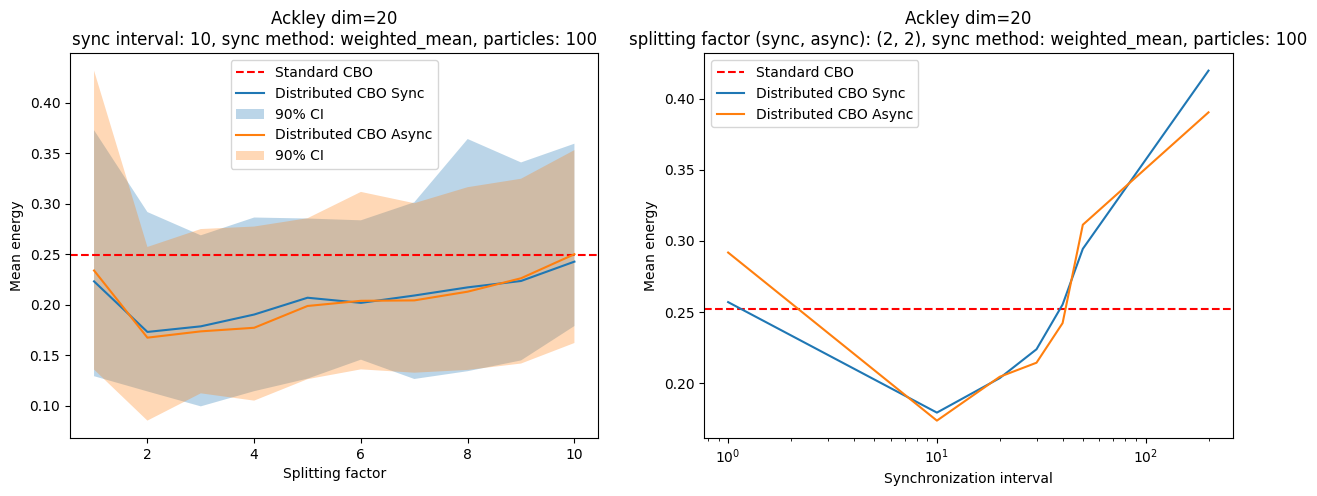

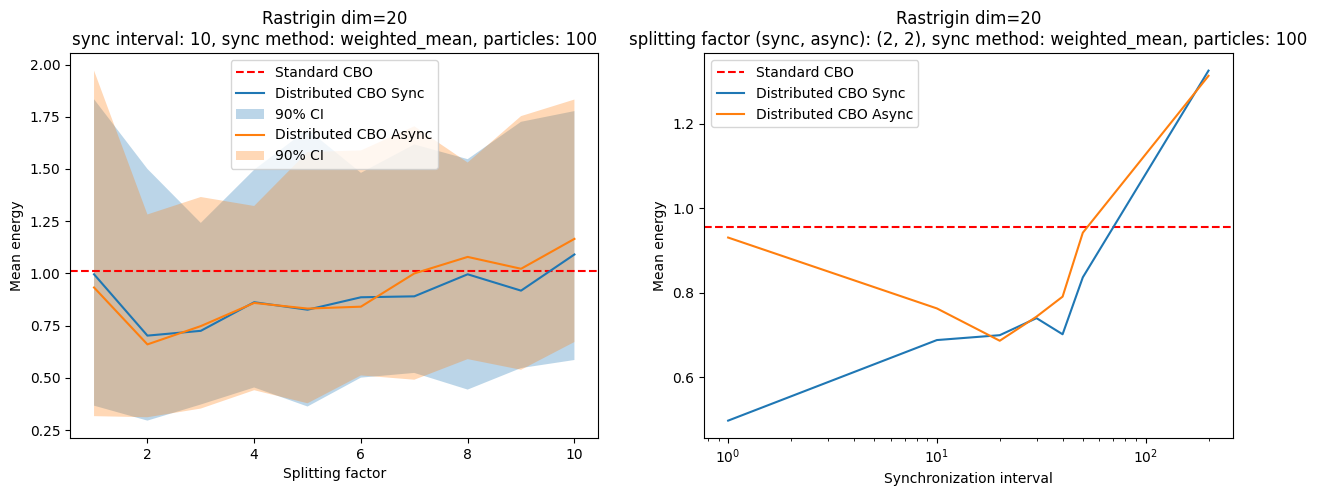

In [13]:
run_experiment(Ackley(), d=20, n=100)
run_experiment(Rastrigin(), d=20, n=100)

Standard CBO:
Average energy: 0.007160947789133676, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.00928514003753662

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.007758611504339985, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.021863460540771484
Splitting factor: 2, average energy: 0.006889437288445155, success_rate: 0.01, function evaluations: 20200.0, execution time: 0.02392940402030945
Splitting factor: 3, average energy: 0.005593216422756786, success_rate: 0.03, function evaluations: 20233.666666666668, execution time: 0.026859456698099773
Splitting factor: 4, average energy: 0.004686851245641055, success_rate: 0.05, function evaluations: 20225.25, execution time: 0.030216605067253113
Splitting factor: 5, average energy: 0.004937958022587896, success_rate: 0.05, function evaluations: 20220.2, execution time: 0.03405375957489014
Splitting factor: 6, average energy: 0.004197172239504443, success_rate:

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.003965660751172173, success_rate: 0.12, function evaluations: 20200.0, execution time: 0.008953170776367187

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.003883176363066276, success_rate: 0.07, function evaluations: 20200.0, execution time: 0.01745183229446411
Splitting factor: 2, average energy: 0.002598309661991572, success_rate: 0.19, function evaluations: 20200.0, execution time: 0.019065526723861696
Splitting factor: 3, average energy: 0.0016297910568521701, success_rate: 0.33, function evaluations: 20233.666666666668, execution time: 0.022340667247772217
Splitting factor: 4, average energy: 0.0012691484868417647, success_rate: 0.41, function evaluations: 20225.25, execution time: 0.026559913754463194
Splitting factor: 5, average energy: 0.0008570359595559296, success_rate: 0.55, function evaluations: 20220.2, execution time: 0.030189825534820556
Splitting factor: 6, average energy: 0.0007959585376521971, success_rate: 0.6, 

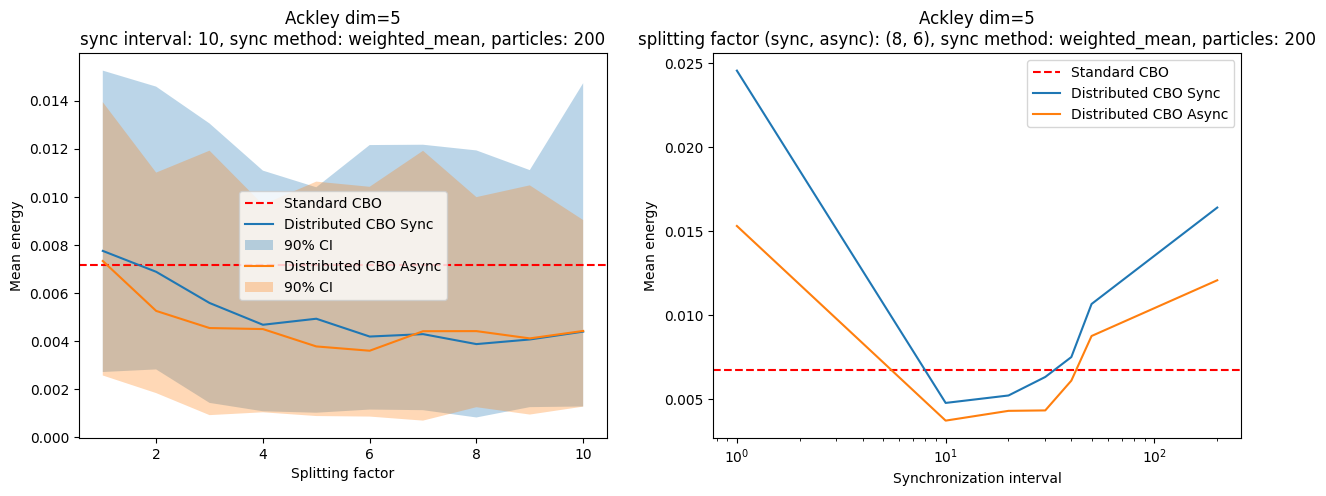

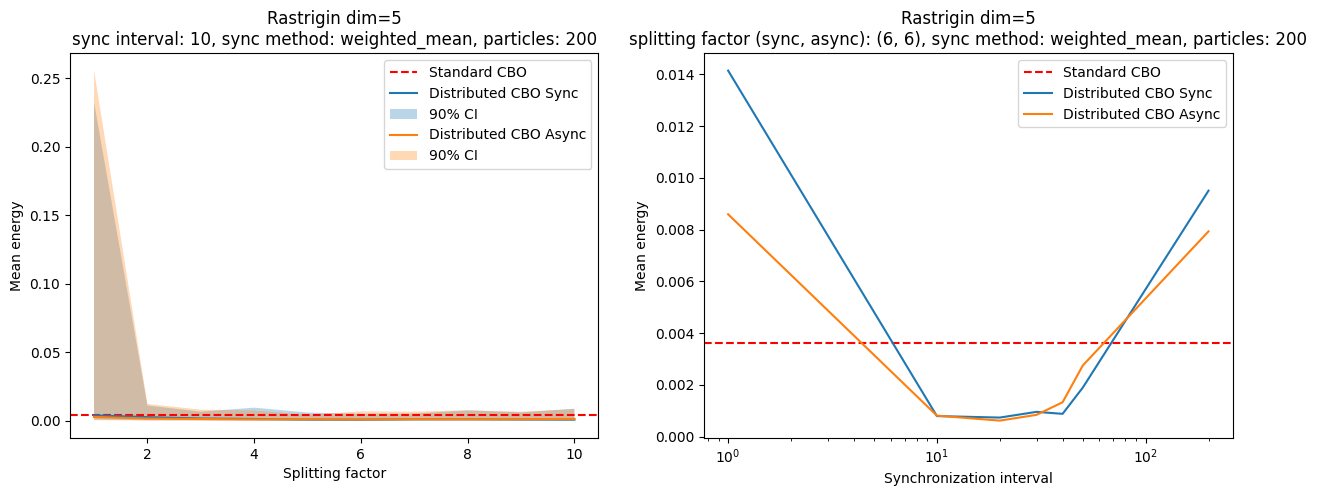

In [14]:
run_experiment(Ackley(), d=5, n=200)
run_experiment(Rastrigin(), d=5, n=200)

Standard CBO:
Average energy: 0.03340165763745029, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.012035188674926757

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.03272298576875032, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.021033942699432373
Splitting factor: 2, average energy: 0.026300710205804823, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.024221750497817992
Splitting factor: 3, average energy: 0.027143155848082134, success_rate: 0.0, function evaluations: 20233.666666666668, execution time: 0.02857536792755127
Splitting factor: 4, average energy: 0.027925273972119857, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.032499523758888246
Splitting factor: 5, average energy: 0.027744701877960853, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.03626377391815185
Splitting factor: 6, average energy: 0.02711633545493486, success_rate: 0.0, 

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.1339915918703695, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.011698145866394043

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.1333404537014843, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.020162460803985597
Splitting factor: 2, average energy: 0.053861536236505456, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.023474998474121093
Splitting factor: 3, average energy: 0.05360625800146188, success_rate: 0.0, function evaluations: 20233.666666666668, execution time: 0.02705349604288737
Splitting factor: 4, average energy: 0.04898652949225557, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.030184627771377565
Splitting factor: 5, average energy: 0.058834695481456215, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.03384271144866943
Splitting factor: 6, average energy: 0.05045738789436776, success_rate: 0.0, function evaluatio

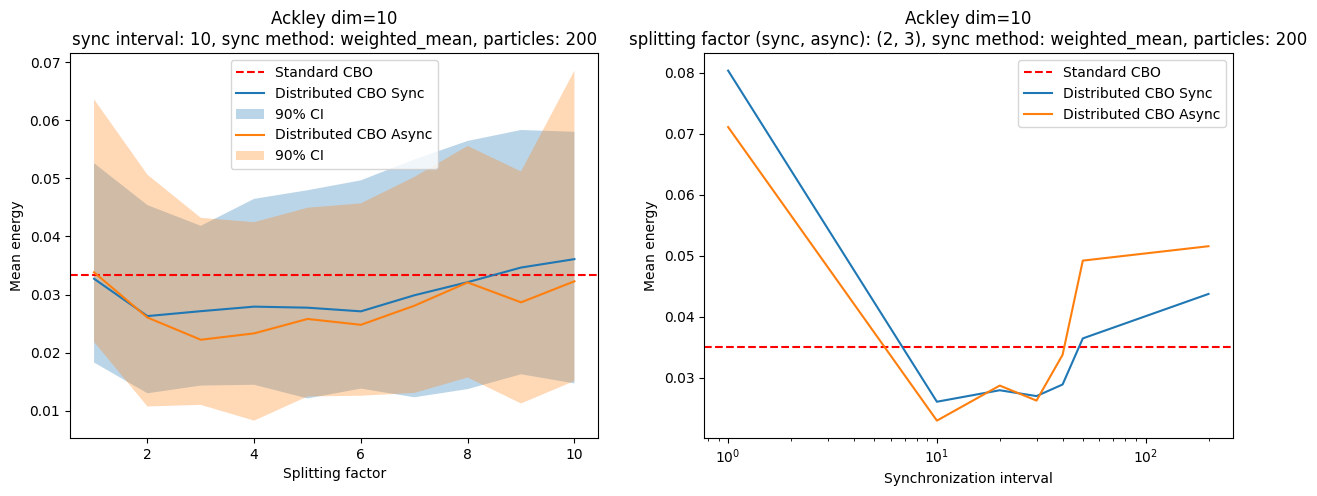

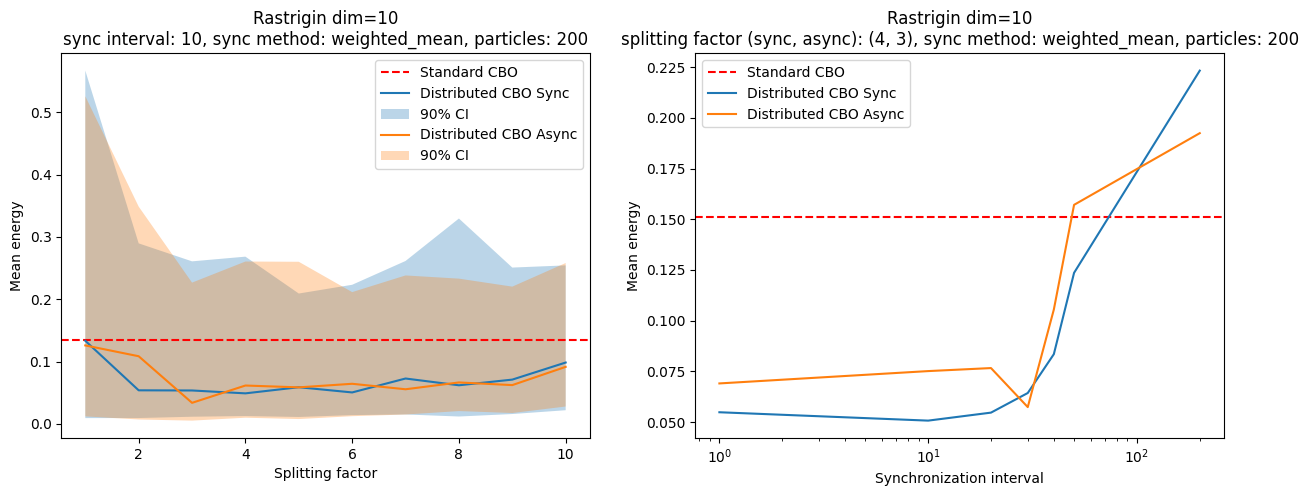

In [15]:
run_experiment(Ackley(), d=10, n=200)
run_experiment(Rastrigin(), d=10, n=200)

Standard CBO:
Average energy: 0.1327259433160486, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.017025759220123293

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.13063913738988875, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.02619701862335205
Splitting factor: 2, average energy: 0.102930603119193, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.027557591199874876
Splitting factor: 3, average energy: 0.10335771043855013, success_rate: 0.0, function evaluations: 20233.666666666668, execution time: 0.03315081755320231
Splitting factor: 4, average energy: 0.09992420640510291, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.038743122816085815
Splitting factor: 5, average energy: 0.10227470097519431, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.044443012714385985
Splitting factor: 6, average energy: 0.10767096419907185, success_rate: 0.0, functio

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.5619443959354411, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.017803423404693604

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.635244300415822, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.02491121530532837
Splitting factor: 2, average energy: 0.42341619297709954, success_rate: 0.0, function evaluations: 20200.0, execution time: 0.026402546167373656
Splitting factor: 3, average energy: 0.40919033548965666, success_rate: 0.0, function evaluations: 20233.666666666668, execution time: 0.03091609716415405
Splitting factor: 4, average energy: 0.46362125083061284, success_rate: 0.0, function evaluations: 20225.25, execution time: 0.04032579004764557
Splitting factor: 5, average energy: 0.4273190044456101, success_rate: 0.0, function evaluations: 20220.2, execution time: 0.0464278507232666
Splitting factor: 6, average energy: 0.4590219177161655, success_rate: 0.0, function evaluations: 2028

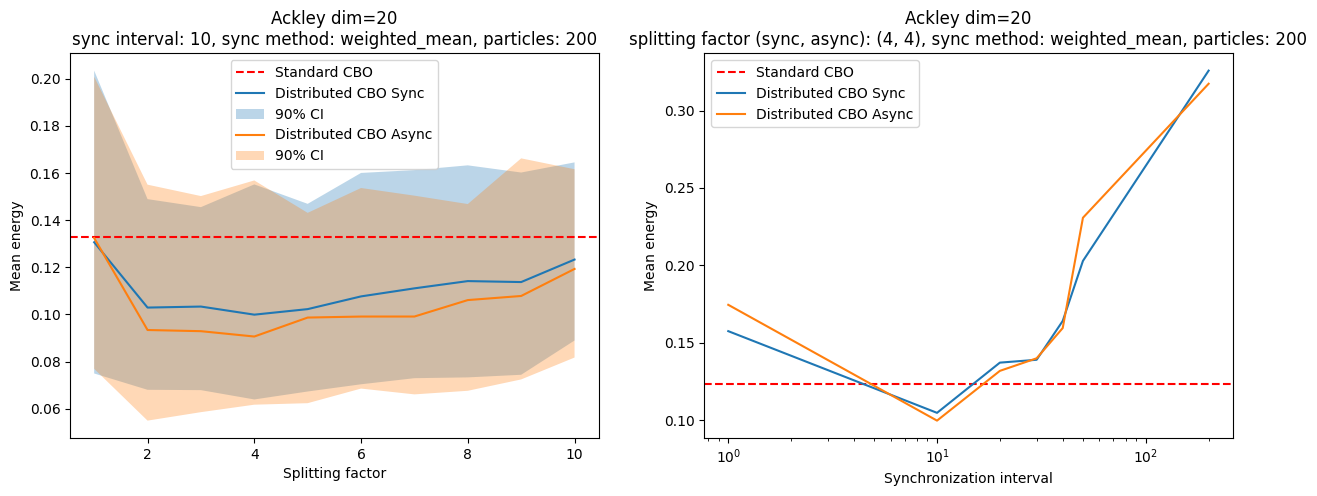

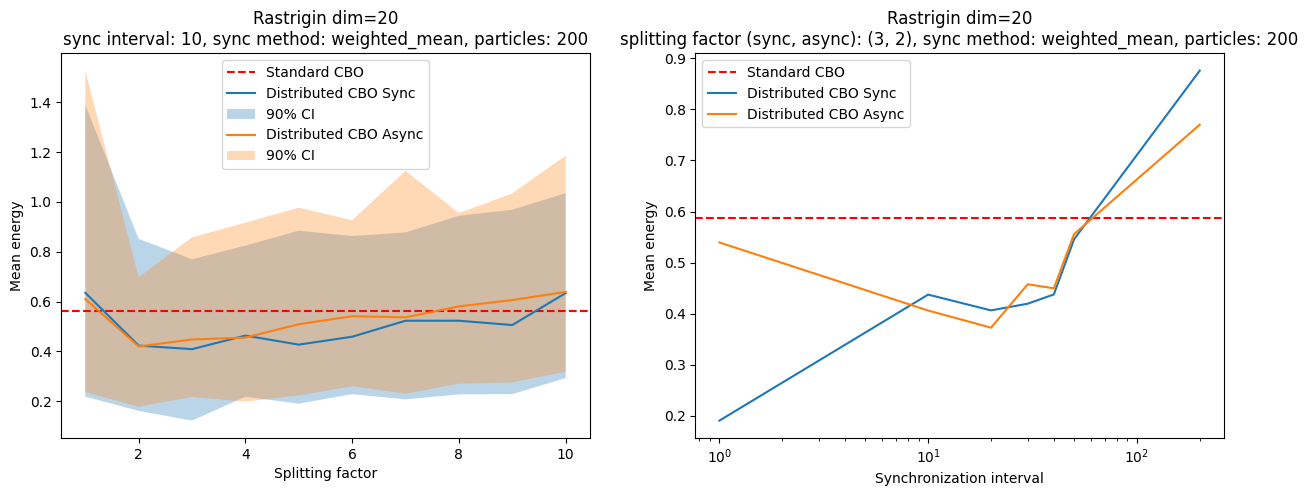

In [16]:
run_experiment(Ackley(), d=20, n=200)
run_experiment(Rastrigin(), d=20, n=200)

Standard CBO:
Average energy: 0.002728927822227778, success_rate: 0.04, function evaluations: 101000.0, execution time: 0.025385236740112303

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.0029562560540257188, success_rate: 0.04, function evaluations: 101000.0, execution time: 0.03509706735610962
Splitting factor: 2, average energy: 0.003237590799713974, success_rate: 0.05, function evaluations: 101000.0, execution time: 0.03355144500732422
Splitting factor: 3, average energy: 0.0028238929361141807, success_rate: 0.07, function evaluations: 101067.33333333333, execution time: 0.038206393718719485
Splitting factor: 4, average energy: 0.002350222636686272, success_rate: 0.12, function evaluations: 101050.5, execution time: 0.045955942273139955
Splitting factor: 5, average energy: 0.0021376378750432856, success_rate: 0.12, function evaluations: 101040.4, execution time: 0.0519869647026062
Splitting factor: 6, average energy: 0.002010690597983089, succe

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.0008878299827898673, success_rate: 0.55, function evaluations: 101000.0, execution time: 0.028873701095581055

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.0007069367736928456, success_rate: 0.6, function evaluations: 101000.0, execution time: 0.05621853828430176
Splitting factor: 2, average energy: 0.0006419037841482123, success_rate: 0.65, function evaluations: 101000.0, execution time: 0.04968146324157715
Splitting factor: 3, average energy: 0.00046851650118497903, success_rate: 0.74, function evaluations: 101067.33333333333, execution time: 0.04956729094187418
Splitting factor: 4, average energy: 0.000504664075921113, success_rate: 0.8, function evaluations: 101050.5, execution time: 0.05193401336669922
Splitting factor: 5, average energy: 0.00045369366179564, success_rate: 0.87, function evaluations: 101040.4, execution time: 0.05726158332824707
Splitting factor: 6, average energy: 0.00036721133850132765, success_rate: 0.89,

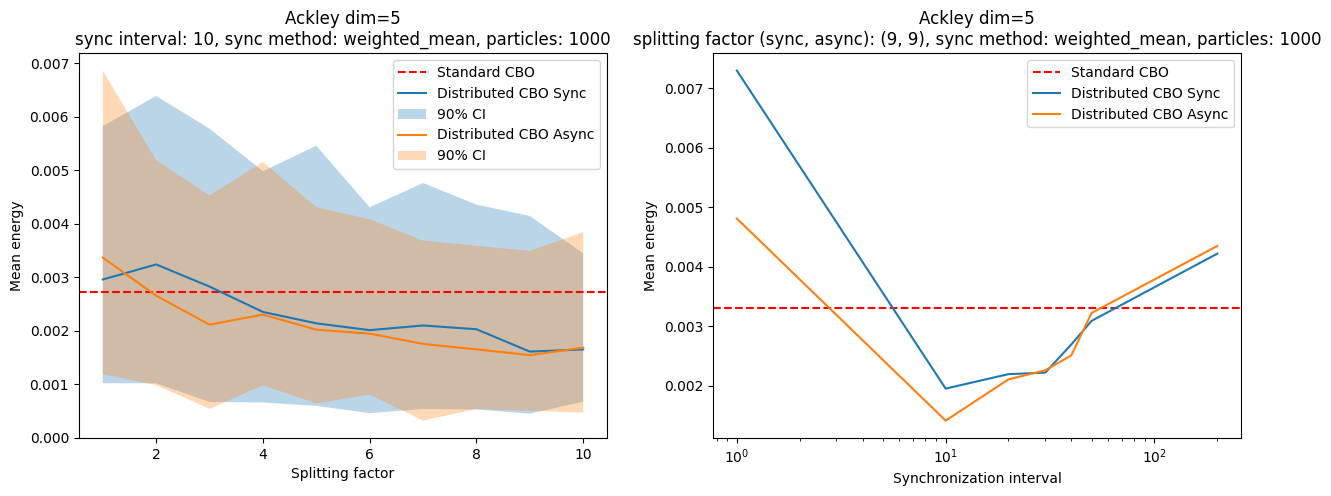

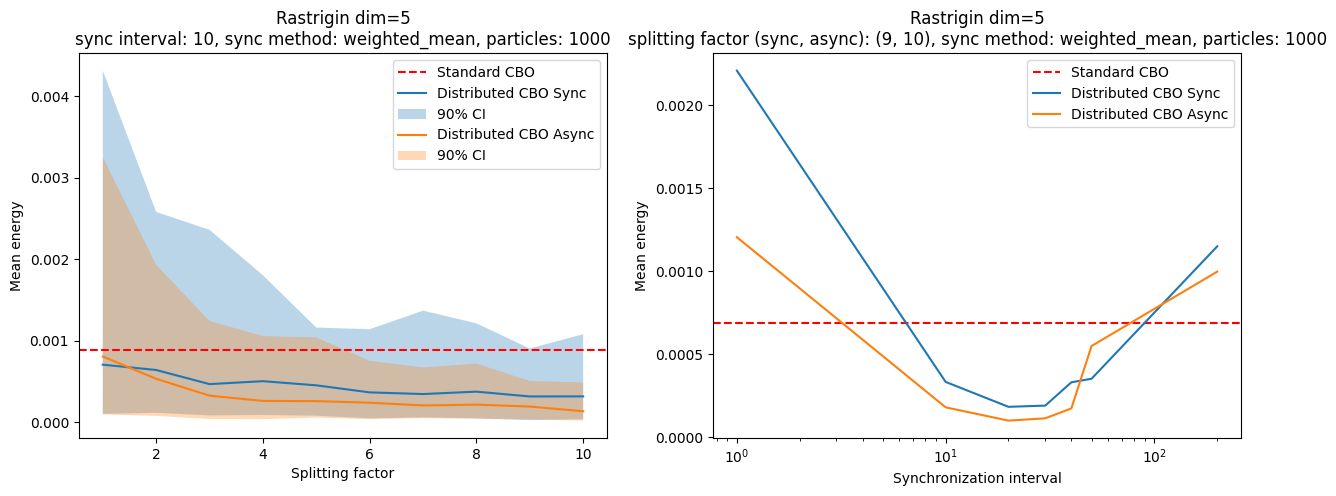

In [17]:
run_experiment(Ackley(), d=5, n=1000)
run_experiment(Rastrigin(), d=5, n=1000)

Standard CBO:
Average energy: 0.019724142648268828, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.038882763385772706

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.01917853556018878, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.0530247688293457
Splitting factor: 2, average energy: 0.01771438713547413, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.050952688455581666
Splitting factor: 3, average energy: 0.014001347918176865, success_rate: 0.0, function evaluations: 101067.33333333333, execution time: 0.05204322655995687
Splitting factor: 4, average energy: 0.01285944139292683, success_rate: 0.0, function evaluations: 101050.5, execution time: 0.05637580454349518
Splitting factor: 5, average energy: 0.012691825429689718, success_rate: 0.0, function evaluations: 101040.4, execution time: 0.06241488218307495
Splitting factor: 6, average energy: 0.011948756538860739, success_rate: 0.0,

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.010073314721321225, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.04941365003585815

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.011411851483566339, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.06582980155944824
Splitting factor: 2, average energy: 0.007370806654623952, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.06302613735198975
Splitting factor: 3, average energy: 0.005196803131329109, success_rate: 0.0, function evaluations: 101067.33333333333, execution time: 0.06336349964141846
Splitting factor: 4, average energy: 0.004692540197418094, success_rate: 0.0, function evaluations: 101050.5, execution time: 0.06697533547878265
Splitting factor: 5, average energy: 0.0038517072812595645, success_rate: 0.06, function evaluations: 101040.4, execution time: 0.07561323165893555
Splitting factor: 6, average energy: 0.004321089436458791, success_rate: 0.04, function

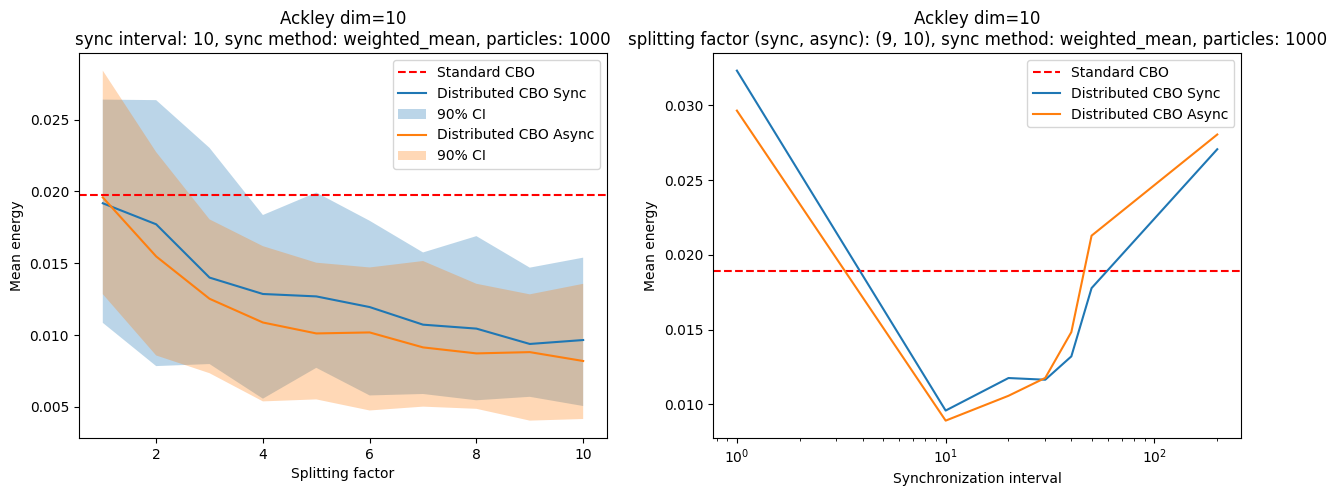

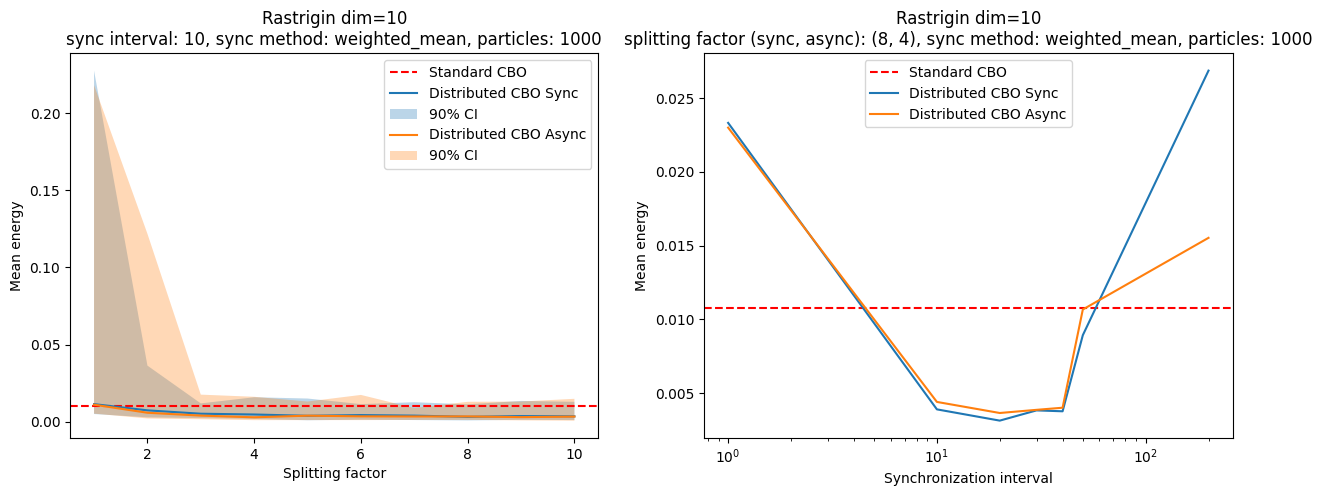

In [18]:
run_experiment(Ackley(), d=10, n=1000)
run_experiment(Rastrigin(), d=10, n=1000)

Standard CBO:
Average energy: 0.05700352175115819, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.07856019973754882

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.057609203203038195, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.07910759687423706
Splitting factor: 2, average energy: 0.04760315275075877, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.07588445425033569
Splitting factor: 3, average energy: 0.042481551830248154, success_rate: 0.0, function evaluations: 101067.33333333333, execution time: 0.07729284604390463
Splitting factor: 4, average energy: 0.037267120673556864, success_rate: 0.0, function evaluations: 101050.5, execution time: 0.08473177373409271
Splitting factor: 5, average energy: 0.036326312847200004, success_rate: 0.0, function evaluations: 101040.4, execution time: 0.08757315111160278
Splitting factor: 6, average energy: 0.034475690726818886, success_rate: 0.0,

/var/folders/hm/3vrj0gkd6vlf68r7t8sqs86m0000gp/T/ipykernel_2486/2271721482.py:121: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Average energy: 0.19272305210334292, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.09090015649795533

Distributed CBO (synchronous communication):
Splitting factor: 1, average energy: 0.18198762244806949, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.21926137208938598
Splitting factor: 2, average energy: 0.1305487118451671, success_rate: 0.0, function evaluations: 101000.0, execution time: 0.1473724901676178
Splitting factor: 3, average energy: 0.10695215508388367, success_rate: 0.0, function evaluations: 101067.33333333333, execution time: 0.12821462790171306
Splitting factor: 4, average energy: 0.10812313064803943, success_rate: 0.0, function evaluations: 101050.5, execution time: 0.13269712030887604
Splitting factor: 5, average energy: 0.10297613655764862, success_rate: 0.0, function evaluations: 101040.4, execution time: 0.12757652139663697
Splitting factor: 6, average energy: 0.09192302851000128, success_rate: 0.0, function evaluations

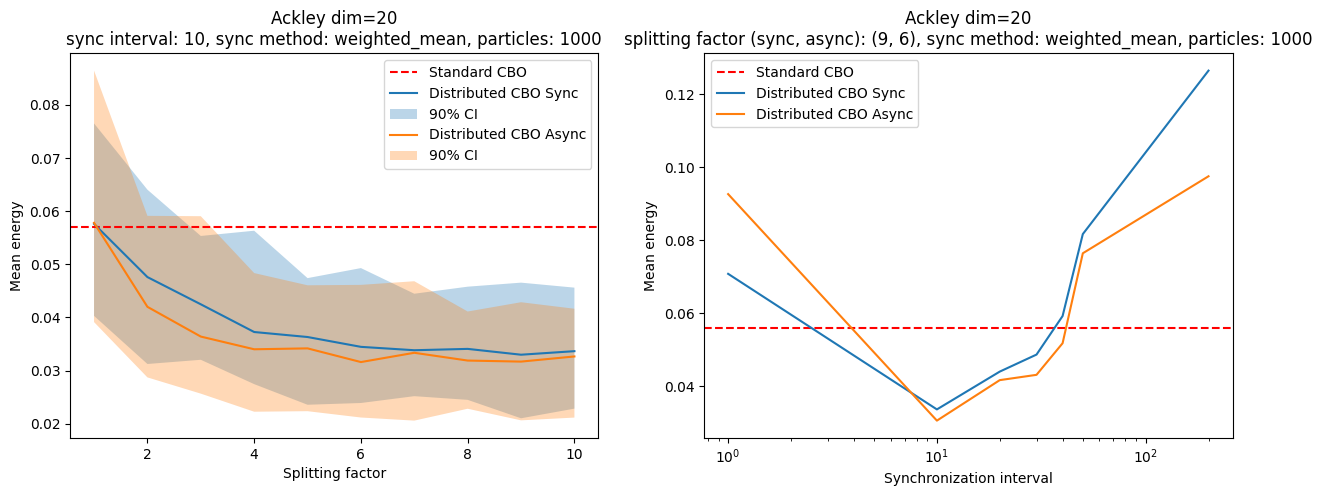

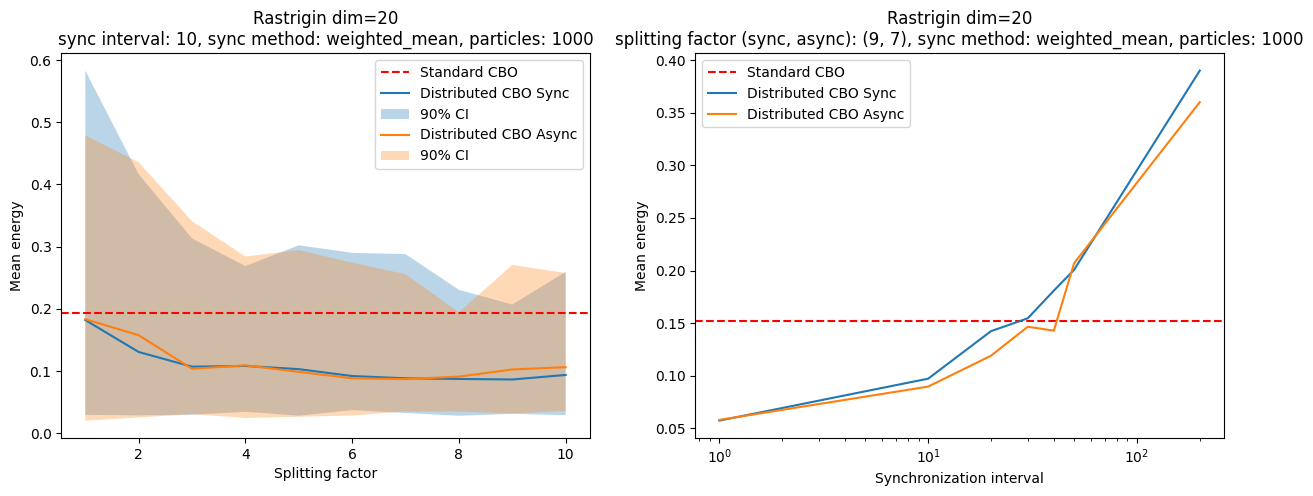

In [20]:
run_experiment(Ackley(), d=20, n=1000)
run_experiment(Rastrigin(), d=20, n=1000)